In [1]:
# Libraries used:
import rebound
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from math import *
import os
from IPython.display import display, clear_output
from ipywidgets import IntProgress
from IPython.display import display
import time
import pandas as pd

# Algunas configuraciones generales:
plt.style.use('seaborn-whitegrid')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 19
# mpl.rcParams['lines.linewidth'] = 11
# mpl.rcParams['lines.markersize'] = 11

In [10]:
# K2:K1 resonance?
K2 = 2
K1 = 1
RESO = str(K2) + '-' + str(K1) # String "K2-K1"

# CASE? (angular momentum and mass ratio)
AMnorm = 0.7 #  0<AMnorm<1
AM_str = str(AMnorm)
m21 = 20 # = m2/m1 
# primary mass (fixed)
m0 = 1  
# Planet to study? (1 or 2)
PLANETA = '1'

# In the next cell are the planetary initial conditions

# OTHER SETUP:
# If ANGLE = 0 => The angles: (0, 360). If ANGLE = 1 => The angles: (-180,180). 
ANGLE = 1
# Use theta instead of sigma? 
THETA = True
# Plot mindis surface?
MINDIS = True
# Filter according RHtol? (encounter if mindis<RHtol)
RHtol = 3
# Load numerical integration to compare it with model in other notebook?
COMPARAR = False
# Save integration data and plots (MODO = 1 only can save plots)
SAVE_data = False
SAVE_plot = False

# Directory and file names:
COMUN = "/home/juan/Escritorio/TESIS/"  # Common path
# (to be saved) data directory
dir_data = COMUN + "PROGRAMAS/REBOUND/Planetario/"+RESO+"/metodo2/m21="+str(m21)+"/AM="+str(AMnorm)+"/ACR1/"
dir_plot = dir_data
file_data1 = "planeta1.txt"
file_data2 = "planeta2.txt"
# H surface data directory (to get resonant angles):
dir_H = COMUN + "PROGRAMAS/Hamiltoniano/Hasigma_planetario/COPLANAR/" + RESO +"/"+ CASO + "/metodo2/"
#dir_H = COMUN + "PROGRAMAS/Hamiltoniano/Hasigma_planetario/COPLANAR/" + RESO + "/prueba/"
file_H = "HSUP" + PLANETA + "_high_RHtol=0.00_AM=" + AM_str + ".dat" # filename

# Image format and quality (in dpi)
formato = "jpg"
cal     = 100
file_plot1 = "planeta1" +"."+ formato
file_plot2 = "planeta2" +"."+ formato
file_plot3 = "otros" +"."+ formato

In [13]:
# PLANETARY INITIAL CONDITIONS
# This notebook was designed to perform numerical integrations of resonant 2-planet systems
# and compare the results with the H-surface model (Pons & Gallardo 2022) but it can be used 
# with general purpose changing all initial elements manually at the end of this cell.
# The initial elements are: a1i, e1i, w1i (long. of peri.), l1i (mean long.), a2i, e2i, w2i, l2i. 

# radian-degree factors convertion
G2R = pi/180
R2G = 180/pi

# Internal = 1 ; External = 2
m2 = 0.001 # fixed
m1 = m2/m21

# Initial semi-major axis:
a2i = 1 # fixed
a1o = a2i*(((K1/K2)**2)*((m0+m1)/(m0+m2)))**(1/3) # nominal a1 is defined by resonance and masses

# DYNAMICAL MAP SETUP:
# Map's grid deltas:
de = 0.05 # e goes from 0 to 1 always
da = 0.001 #0.01 y 0.0002

# semi-major axis window with respect to a1o:
amax = 1.01*a1o
amin = 0.98*a1o
print('Planet 1 semi-major axis goes from',amin,'to',amax,'\n')
a1i = np.arange(amin,amax,da)  

# AM calculation:
G = 0.01720209895**2
mu1 = G*(m1 + m0)*a1i    # vector
mu2 = G*(m2 + m0)*a2i    # escalar
beta1 = m1*m0/(m1 + m0)
beta2 = m2*m0/(m2 + m0)
C1 = beta1*np.sqrt(mu1)  # vector
C2 = beta2*np.sqrt(mu2)  # escalar
AM_min = 0
AM_max = C1 + C2         # vector
# Angular momentum:
AM = AMnorm*AM_max       # vector

# 0.6299605249474366     0.25   0.0  0.0  0.0        0.0    180.0
# 1.0     0.873350029764019   0.0  0.0  0.0        0.0    180.0
# Planetary I.C.:
w2i = 0 # fixed
l2i = 0 # fixed
# e1i = 0.90
e1i = np.arange(0,1,de)
w1i = 0
# thetai = 0
# sigmai = 0
s1i = thetai # decide which resonant angle to use

Ny = len(e1i)
Nx = len(a1i)
# print(Nx,Ny)

# I.C. defined by equations:
C3 = np.outer(np.sqrt(1-e1i**2),C1)   # vector

# print(AM.shape)
# print(C3.shape)

e2i = np.sqrt( 1 - ((np.tile(AM, [Ny, 1]) - C3)/(C2))**2 )   # matriz len(C3[0])
# l1i = (thetai + K2*l2i)/K1
# l1i = (sigmai + K2*l2i - (K2-K1)*w1i)/K1

#print('Planet 2 eccentricity matrix:','\n',e2i,'\n')
# e2i = e2i.T
# print(e2i.shape)
# print(C3.shape)
# print(e2i[1,3])

# e1i,w1i and s1i (thetai or sigmai) defines name of folder to load/save data
# caso_str = 'e1=%.2f_w1=%.0f_s1=%.0f' % (e1i,w1i,s1i)
caso_str = 'dinmap'

dir_data = dir_data + caso_str + "/"
dir_plot = dir_plot + caso_str + "/"

Nint = Nx*Ny
NintR = Nx*Ny - np.count_nonzero(np.isnan(e2i))
print('Total number of integrations a priori:',Nint)
print('Real total number of integrations:',NintR,'\n')
# print("Intitial conditions are (a, e, varpi, lambda):")
# print("Planet 1:            ", round(a1i,4), round(e1i,3), " ", w1i, " ", l1i)
# print("Planet 2:            ", round(a2i,4), "   ", round(e2i,3), " ", w2i, " ", l2i) 

Planet 1 semi-major axis goes from 0.6171659501847725 to 0.6360587853945104 

(20, 19)
(20, 19)
Total number of integrations a priori: 380
Real total number of integrations: 380 



In [ ]:
# FUNCIÓN PARA OBTENER EL ELEMENTO DE UN ARRAY MÁS CERCANO A UN VALOR:
def nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [ ]:
# LOAD DATA:
Din_Hsup = pd.read_csv(dir_H + file_H, delimiter=r"\s+")
H = Din_Hsup['R'].values

# Remove outliers (https://www.kite.com/python/answers/how-to-remove-outliers-from-a-pandas-dataframe-in-python) 
z_scores = sc.stats.zscore(H)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
Din_Hsup = Din_Hsup[filtered_entries]      

if (MINDIS):    
    Din_Hsup = Din_Hsup[Din_Hsup['mindis'].values >= RHtol]
    MD_sup = Din_Hsup['mindis'].values
    
# Obtain variables from dataframe:
E_sup = Din_Hsup['e' + PLANETA].values
W_sup = Din_Hsup['deltavarpi'].values % 360
H_sup = -Din_Hsup['R'].values
S_sup = Din_Hsup['sigma1'].values % 360

res_angle = "σ"
if (THETA):
    S_sup = (S_sup - (K2-K1)*W_sup) % 360
    res_angle = "θ"
    
if (ANGLE == 1):
    W_sup = np.where(W_sup>180, W_sup - 360, W_sup)
    S_sup = np.where(S_sup>180, S_sup - 360, S_sup)
    
# Lets obtain the initial lambdas of the interior planet for each pairs (a, e):

E = np.arange(0,1,0.01)

thetai 
sigmai 

l1i = (thetai + K2*l2i)/K1
l1i = (sigmai + K2*l2i - (K2-K1)*w1i)/K1

In [4]:
# DOBLE LOOP AL INTEGRADOR REBOUND PARA CONSTRUIR EL MAPA DINAMICO

# Inicializo matrices
deltaA1 = np.zeros([Nx, Ny])
deltaA2 = np.zeros([Nx, Ny])
deltaE1 = np.zeros([Nx, Ny])
deltaE2 = np.zeros([Nx, Ny])
meanA1  = np.zeros([Nx, Ny])
meanA2  = np.zeros([Nx, Ny])
meanE1  = np.zeros([Nx, Ny])
meanE2  = np.zeros([Nx, Ny])

# Defino tiempo total, paso, puntos, etc. para c/int:
Ttot  = 1e2   # total int. time
d_out = 1    # output step
dT    = 0.01  # paso de la int.
NintTot = int(Ttot/dT)
Nout  = int(Ttot/d_out) # puntos en la salida en cada integracion

# Para todas las ints:
NoutTot = Nout*NintR    # puntos en la salida en todas las ints
Ncases = Nx*Ny
Nenc = 0

# Voy a usar todos los puntos para calcular las cosas
Nout = NintTot

# Barra para indicar el progreso:
print('Progress:')
barra = IntProgress(min=0, max=Ncases) # instantiate the bar
display(barra) # display the bar

for i in range(Nx):
    
    # Encuentros:
    RHill = ((a1i[i]+a2i)/2)*((m1+m2)/(3*m0))**(1/3) # mutual Hill radius
    dEnc = RHtol*RHill # criteria for encounter
    
    for j in range(Ny):        

        # Chequeamos que la excentricidad del planeta 2 sea válida 
        if ( ~np.isnan(e2i[j,i]) ):
            
            # CONFIGURACÓN DE LA SIMULACIÓN

            # Creo sim
            sim = rebound.Simulation()

            # Eligo algoritmo de integración:
            # sim.integrator = "whfast"
            sim.integrator = "mercurius" 
            sim.ri_mercurius.hillfac = 5. #  Hill distance at which MERCURIUS switches from WHFast to IAS15

            # Eligo el sistema de ref.:
            # sim.ri_whfast.coordinates = 'jacobi' #default
            # sim.ri_whfast.coordinates = 'democraticheliocentric' # ~ Poincare
            # sim.ri_whfast.coordinates = 'whds'
            sim.ri_mercurius.coordinates = 'democraticheliocentric'

            # Defino unidades:
            sim.units = ('yrs', 'AU', 'Msun')
            #sim.t = Ttot
            sim.dt = dT

            # Mejorar performance y accuaracy:
            # sim.ri_whfast.safe_mode = 0
            # sim.ri_whfast.corrector = 11 # Solo en Jacobi

            KG2 = sqrt(sim.G)
            #print(KG2)

            # Configuración de encuentros:
            sim.exit_min_distance = dEnc # activate encounter flag

            # DEFINO OBJETOS:
            star = sim.add(m=1)            
            pla1 = sim.add(m=m1, a=a1i[i], e=e1i[j], inc=0*G2R, pomega=w1i*G2R, Omega=0*G2R, l=l1i*G2R)
            pla2 = sim.add(m=m2, a=a2i, e=e2i[j,i], inc=0*G2R, pomega=w2i*G2R, Omega=0*G2R, l=l2i*G2R)
            # pla1 = sim.add(m=0.0000000001, a=3.2757, e=0.55, inc=0*G2R, pomega=0*G2R, Omega=0*G2R, M=0*G2R)
            # pla2 = sim.add(m=0.0001, a=5.2, e=0.3,     inc=0*G2R, pomega=0*G2R, Omega=0*G2R, M=0*G2R)

            particles = sim.particles

            # sim.status()

            
            # INTEGRACIÓN NUMÉRICA:

            # Integro con REBOUND

            # Inicializo variables:
            times = np.linspace(0, Ttot, Nout)
            t1 = times
            t2 = times
            a1 = np.zeros(Nout)
            e1 = np.zeros(Nout)
            # w1 = np.zeros(Nout)
            # l1 = np.zeros(Nout)
            a2 = np.zeros(Nout)
            e2 = np.zeros(Nout)
            # w2 = np.zeros(Nout)
            # l2 = np.zeros(Nout)

            try:
                # Integro en pasos (Ttot/Nout) y voy guardando elementos:
                for n,time in enumerate(times):
                    sim.integrate(time, exact_finish_time=0)
                    a1[n] = particles[1].a
                    e1[n] = particles[1].e
                #    w1[i] = (particles[1].pomega)*R2G % 360
                #    l1[i] = (particles[1].l)*R2G % 360
                    a2[n] = particles[2].a
                    e2[n] = particles[2].e
                #    w2[i] = (particles[2].pomega)*R2G % 360
                #    l2[i] = (particles[2].l)*R2G % 360
            except rebound.Encounter as error:
#                 print(error)
                Nenc += 1
                
            # Calculo algunas cositas al terminar la int:    
            deltaA1[i,j] = a1.max() - a1.min()  
            deltaA2[i,j] = a2.max() - a2.min()    
            deltaE1[i,j] = e1.max() - e1.min()    
            deltaE2[i,j] = e2.max() - e2.min()  
            meanA1[i,j]  = a1.mean() 
            meanA2[i,j]  = a2.mean()   
            meanE1[i,j]  = e1.mean()   
            meanE2[i,j]  = e2.mean() 

        else:

            deltaA1[i,j] = np.nan
            deltaA2[i,j] = np.nan  
            deltaE1[i,j] = np.nan  
            deltaE2[i,j] = np.nan
            meanA1[i,j]  = np.nan
            meanA2[i,j]  = np.nan
            meanE1[i,j]  = np.nan
            meanE2[i,j]  = np.nan

        # sim.status()

        # # Otras cantidades de interés:
        # deltaW = (w1-w2) % 360
        # theta = (K1*l1-K2*l2) % 360
        # s1 = (theta + (K2-K1)*w1) % 360
        # s2 = (theta + (K2-K1)*w2) % 360
        # ds = (theta + (K2-K1)*deltaW) % 360

        # # Acomodo ángulos:
        # w1 = w1 % 360
        # w2 = w2 % 360
        # l1 = l1 % 360
        # l1 = l2 % 360
        # if (ANGLE == 1):
        #     w1 = np.where(w1>180, w1 - 360, w1)
        #     l1 = np.where(l1>180, l1 - 360, l1)
        #     s1 = np.where(s1>180, s1 - 360, s1)
        #     w2 = np.where(w2>180, w2 - 360, w2)
        #     l2 = np.where(l2>180, l2 - 360, l2)
        #     s2 = np.where(s2>180, s2 - 360, s2)
        #     deltaW = np.where(deltaW>180, deltaW - 360, deltaW)
        #     theta = np.where(theta>180, theta - 360, theta)
        #     ds = np.where(ds>180, ds - 360, ds)
        #     angle_yticks = np.arange(-180,270,90)
        # else:
        #     angle_yticks = np.arange(0,450,90)
        
        barra.value += 1 # signal to increment the progress bar
        sim = None # delete simulation
        
# Luego de terminar de integrar todo:
print('All integrations finished succesfully.')
print('There were',Nenc,'encounters in',Ncases,'integrations.')

Progress:


IntProgress(value=0, max=380)

All integrations finished succesfully.
There were 261 encounters in 380 integrations.


/tmp/ipykernel_400706/1610604266.py:6: RuntimeWarning: divide by zero encountered in log10
  pcf = plt.contourf(a1i, e1i, np.log10(np.abs(deltaA1.T)), levels = 100, cmap = 'gist_ncar', alpha = 0.8)  # gist_ncar ; gnuplot
/tmp/ipykernel_400706/1610604266.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(pcf, cax=pos_cbar)#,shrink = 0.9)


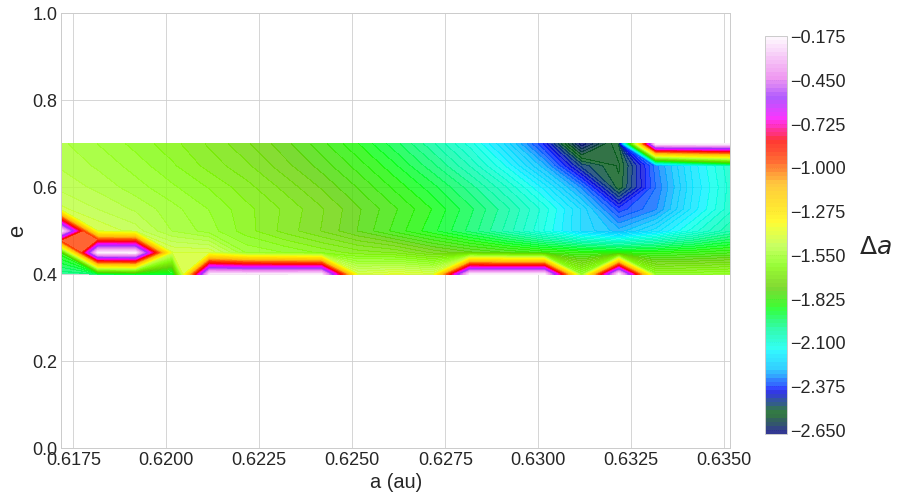

In [15]:
# GRÁFICOS PLANETA 1
fig = plt.figure(figsize=(12,8)) 

# dynamical map
# plt.scatter(a, e, c = da, s = 10, alpha = 1, cmap = 'gist_ncar');
pcf = plt.contourf(a1i, e1i, deltaA1.T, levels = 100, cmap = 'gist_ncar', alpha = 0.8)  # gist_ncar ; gnuplot

# # semi-analytical model
# plt.plot(a_sl, e_sl, c = 'k', lw = 1, alpha = 1); 
    
# plt.xticks(Xticks)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) 
plt.xlabel('a (au)')
plt.ylabel('e', fontsize = 22) 

# Colorbar
pos_cbar = fig.add_axes([0.94,0.15,0.025,0.69]) # [left, bottom, width, height] (normalized) 
cbar = plt.colorbar(pcf, cax=pos_cbar)#,shrink = 0.9)
cbar.set_label('$\Delta a$', size=25, rotation = 0, labelpad=30)#, y = 1.1)    

plt.grid(ls=':')

#fig.tight_layout()
if (SAVE_plot):
    if not os.path.exists(dir_plot):
        os.makedirs(dir_plot)
    plt.savefig(dir_plot + file_plot1, bbox_inches = 'tight', dpi = int(cal), format = formato);  
    print('Saved in:', dir_plot + file_plot1)

plt.show();

TypeError: Shapes of x (19, 19) and z (19, 20) do not match

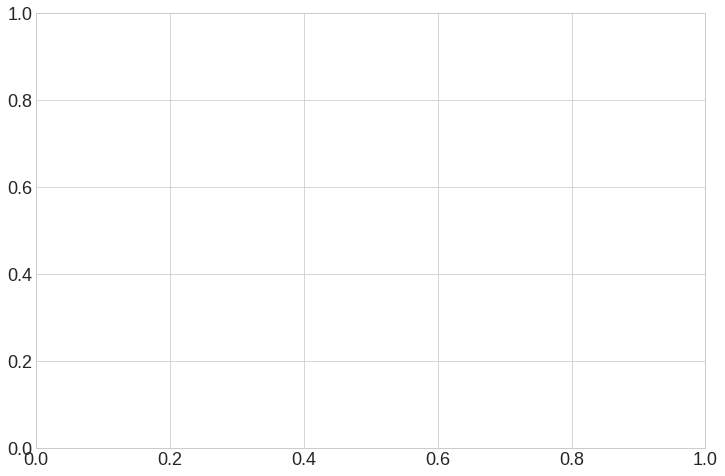

In [6]:
# GRÁFICOS PLANETA 2
fig = plt.figure(figsize=(12,8)) 

# dynamical map
# plt.scatter(a, e, c = da, s = 10, alpha = 1, cmap = 'gist_ncar'); 
a1i_tile = np.tile(a1i, [len(C3[0]), 1])
pcf = plt.contourf(a1i_tile, e2i, deltaA2, levels = 100, cmap = 'gnuplot', alpha = 0.8)  # gist_ncar ; gnuplot

# # semi-analytical model
# plt.plot(a_sl, e_sl, c = 'k', lw = 1, alpha = 1); 
    
# plt.xticks(Xticks)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) 
plt.xlabel('a (au)')
plt.ylabel('e', fontsize = 22) 

# Colorbar
pos_cbar = fig.add_axes([0.94,0.15,0.025,0.69]) # [left, bottom, width, height] (normalized) 
cbar = plt.colorbar(pcf, cax=pos_cbar)#,shrink = 0.9)
cbar.set_label('$\Delta a$', size=25, rotation = 0, labelpad=30)#, y = 1.1)    

plt.grid(ls=':')

#fig.tight_layout()
if (SAVE_plot):
    plt.savefig(dir_plot + file_plot2, bbox_inches = 'tight', dpi = int(cal), format = formato);  
    print('Saved in:', dir_plot + file_plot2)

plt.show();

In [ ]:
# # OTROS GRÁFICOS
# fig, axs = plt.subplots(3, 1, figsize = (16, 7), sharex = 'col', sharey = False)

# # Gráficos: a(t), e(t) y ángulos(t).
# axs[0].plot(t1, deltaW, 's', marker = '.', ms = 1, c='k')
# axs[1].plot(t1, theta, 's', marker = '.', ms = 1, c='k')
# axs[2].plot(t1, ds, 's', marker = '.', ms = 1, c='k')

# # Labels y ticks:
# axs[0].set(ylabel = r'$\Delta\varpi$ (°)', yticks = angle_yticks)
# axs[1].set(ylabel = r'$\theta$ (°)', yticks = angle_yticks)
# axs[2].set(ylabel = r'$\sigma^*$ (°)', xlabel = 't (years)', yticks = angle_yticks);

# if (SAVE_plot):
#     plt.savefig(dir_plot + file_plot3, bbox_inches = 'tight', dpi = int(cal), format = formato);  
#     print('Saved in:', dir_plot + file_plot3)

# plt.show();

In [ ]:
# if ((SAVE_data) and (MODO == 0)):
#     if not os.path.exists(dir_data):
#          os.makedirs(dir_data)
#     formato = "%6.2f %8.6f %8.6f %5.2f %5.2f"
#     nom_cols1 = "    t    a1       e1      w1  lambda1"
#     nom_cols2 = "    t    a2       e2      w2  lambda2"
#     data1 = np.c_[t1, a1, e1, w1, l1]
#     data2 = np.c_[t2, a2, e2, w2, l2]
#     np.savetxt(dir_data + file_data1, data1, fmt=formato, header = nom_cols1, comments='')
#     np.savetxt(dir_data + file_data2, data2, fmt=formato, header = nom_cols2, comments='')
#     print('Saved in:', dir_data)
        
# # Para levantar en otro notebook:    
# if (COMPARAR):
#     %store e1
#     %store deltaW
#     %store s1
# # del e1 
# # del deltaW 
# # del sigma2

In [ ]:
# FIN DEL PROGRAMA